# Using ms2deepscore: How to load data, train a model, and compute similarities.

In [1]:
from pathlib import Path
import os

from matchms.importing import load_from_mgf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint)
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from ms2deepscore import SpectrumBinner
from ms2deepscore.data_generators import DataGeneratorAllInchikeys
from ms2deepscore.models import SiameseModel
from ms2deepscore import MS2DeepScore
from ms2deepscore.models import load_model

## Data loading

Here we define the file location of a small sample of spectrums as well as reference scores data.

In [2]:

from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm

path_cc = "D:/CurrentClamp/all_ephys_CC.csv"
path_fn = "D:/CurrentClamp/all_ephys_feats_FN.csv"
path_waveforrms = "D:/CurrentClamp/waveforms.pkl"
path_waveforrms_cc = "D:/CurrentClamp/CC_waveforms.pkl"


data_ephys_FN = pd.read_csv(path_fn)
data_ephys_CC = pd.read_csv(path_cc)
data_waves_FN = pd.read_pickle(path_waveforrms)
data_waves_CC = pd.read_pickle(path_waveforrms_cc)
data_ephys_CC = data_ephys_CC[data_ephys_CC.columns[1:]] 
data_ephys_FN = data_ephys_FN[data_ephys_FN.columns[1:]] 

data_waves_CC.columns = ['waveforms','trial','exp_name']
data_waves_CC = data_waves_CC[data_waves_CC.trial==1]

In [3]:
FN_LIST = [i[:-3] for i in data_ephys_FN.exp_name]
data_ephys_FN.exp_name = FN_LIST 



data_ephys_CC = data_ephys_CC.dropna()
data_ephys_CC =data_ephys_CC[data_ephys_CC['trialnr']==1.]


data_ephys_CC.filename = [i[:-7] for i in data_ephys_CC.filename]
data_ephys_CC = data_ephys_CC[data_ephys_CC.filename.isin(FN_LIST)]
data_ephys_CC = data_ephys_CC.sort_values('filename')
# data_waves_CC[data_waves_CC] = data_waves_CC[data_waves_CC.trial==1]

In [4]:
data_ephys_CC[data_ephys_CC.columns[:-2]]

,current_first_spike,ap_count,abs_firing_rate,inst_firing_rate,time_to_first_spike,mean_isi,max_isi,min_isi,median_isi,first_thrs,...,first_hwidths,mean_hwidths,median_hwidths,max_hwidths,min_hwidths,first_amp,mean_amp,median_amp,max_amp,min_amp
375,-2.750000e-12,14,0.028003,0.034881,53.15,34.396154,45.85,9.90,37.000,-0.033875,...,1.40,1.433333,1.450,1.45,1.40,0.097313,0.096000,0.095562,0.097313,0.095125
372,2.009688e-10,41,0.082008,0.084816,-38.75,12.130000,18.60,6.70,12.075,-0.050906,...,0.55,0.575000,0.575,0.60,0.55,0.157000,0.157000,0.157000,0.157000,0.157000
369,-2.560938e-10,19,0.038004,0.047202,22.45,27.116667,40.25,6.35,29.975,-0.046219,...,1.10,1.116667,1.100,1.15,1.10,0.097594,0.095302,0.094656,0.097594,0.093656
360,6.162812e-10,40,0.080008,0.081107,-28.80,12.732051,16.35,6.95,12.800,-0.043375,...,0.65,0.679167,0.700,0.70,0.65,0.149375,0.136073,0.134484,0.149375,0.130312
357,-7.673750e-10,48,0.096010,0.096608,-36.00,10.504255,12.10,5.85,10.650,-0.044188,...,0.45,0.445833,0.450,0.45,0.40,0.106969,0.103279,0.102953,0.106969,0.102187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10,-1.575625e-10,11,0.022002,0.032208,0.95,48.790000,72.25,8.00,54.225,-0.039844,...,1.30,1.312500,1.300,1.35,1.30,0.096313,0.096313,0.096313,0.096313,0.096313
8,5.390625e-11,12,0.024002,0.033502,-18.80,43.872727,56.65,6.50,47.650,-0.033219,...,1.45,1.416667,1.400,1.45,1.40,0.092844,0.091708,0.091406,0.092844,0.090875
5,-5.640625e-11,18,0.036004,0.049504,107.95,26.838235,38.25,6.30,30.550,-0.032844,...,1.40,1.425000,1.425,1.45,1.40,0.091500,0.090984,0.090984,0.091500,0.090469
2,-2.336250e-10,5,0.010001,0.071984,-37.60,79.500000,184.60,5.85,63.775,-0.043437,...,1.15,1.200000,1.200,1.25,1.15,0.095781,0.087375,0.087375,0.095781,0.078969


In [5]:

data_waves_FN.exp_name = [i[:-3] for i in data_waves_FN.exp_name]
data_ephys_FN['waveforms'] = data_ephys_FN['exp_name'].map(data_waves_FN.set_index('exp_name')['waveforms'])


In [6]:
data_waves_CC.exp_name = [i[:-3] for i in data_waves_CC.exp_name]
data_ephys_CC['waveforms'] = data_ephys_CC['filename'].map(data_waves_CC.set_index('exp_name')['waveforms'])


In [7]:
data_FN = data_ephys_FN[data_ephys_FN.exp_name.isin(data_ephys_CC.filename)]
data_CC = data_ephys_CC

In [8]:
data_all_CC =data_CC[['current_first_spike', 'ap_count', 'abs_firing_rate',
       'inst_firing_rate', 'time_to_first_spike', 'mean_isi', 'max_isi',
       'min_isi', 'median_isi', 'first_thrs', 'mean_thrs', 'max_thrs',
       'min_thrs', 'median_thrs', 'first_hwidths', 'mean_hwidths',
       'median_hwidths', 'max_hwidths', 'min_hwidths', 'first_amp', 'mean_amp',
       'median_amp', 'max_amp', 'min_amp',]].to_numpy()
data_all_CC = np.array([np.hstack(i) for i in data_all_CC])

data_all_FN =data_FN[['current_at_first_spike', 'ap_count', 'fr', 'inst_fr',
       'time_to_first_spike', 'mean_isi', 'median_isi', 'max_isi', 'min_isi',
       'first_thr', 'mean_thr', 'median_thr', 'min_thr', 'max_thr',
       'mean_width', 'median_width', 'max_width', 'min_width',
       'mean_amplitude', 'median_amplitude', 'min_amplitude', 'max_amplitude',
        ]].to_numpy()
data_all_FN = np.array([np.hstack(i) for i in data_all_FN])

Index(['current_first_spike', 'ap_count', 'abs_firing_rate',
       'inst_firing_rate', 'time_to_first_spike', 'mean_isi', 'max_isi',
       'min_isi', 'median_isi', 'first_thrs', 'mean_thrs', 'max_thrs',
       'min_thrs', 'median_thrs', 'first_hwidths', 'mean_hwidths',
       'median_hwidths', 'max_hwidths', 'min_hwidths', 'first_amp', 'mean_amp',
       'median_amp', 'max_amp', 'min_amp', 'trialnr', 'filename', 'waveforms'],
      dtype='object')


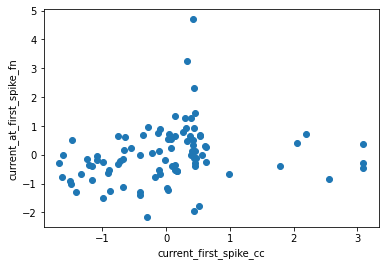

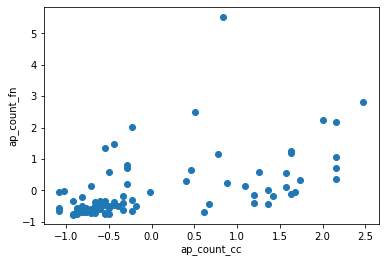

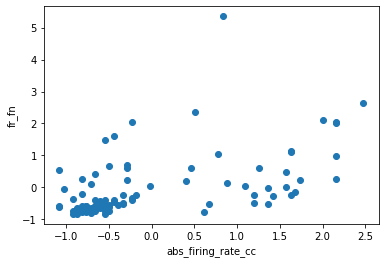

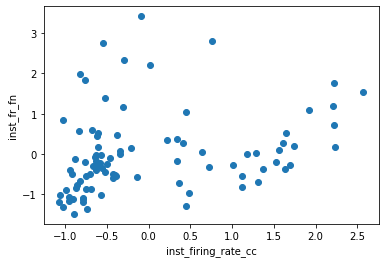

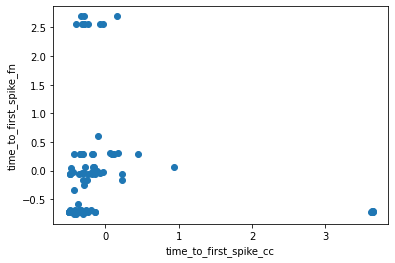

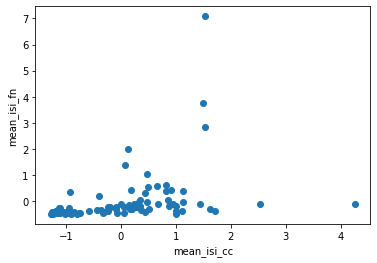

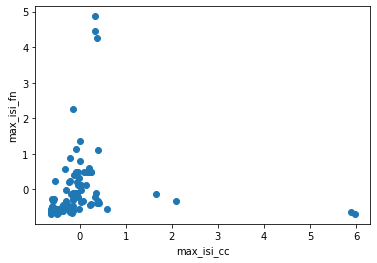

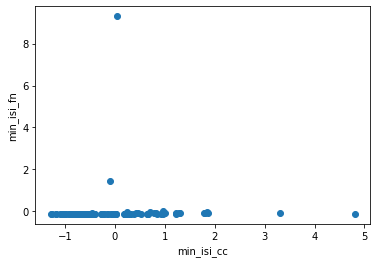

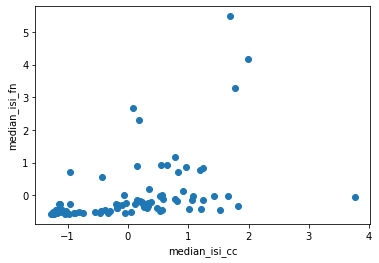

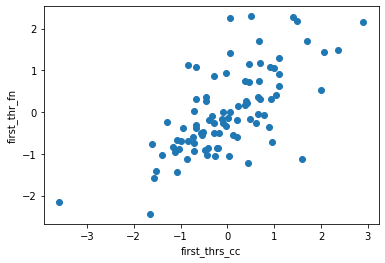

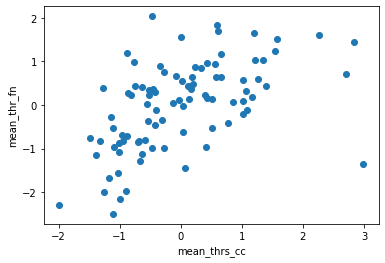

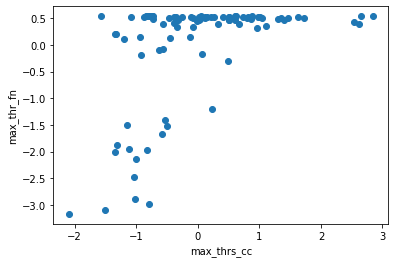

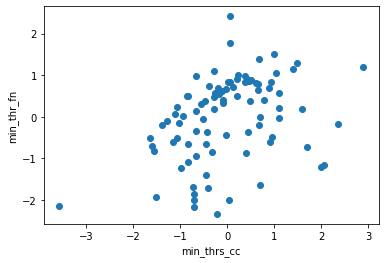

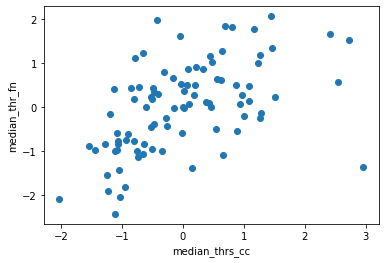

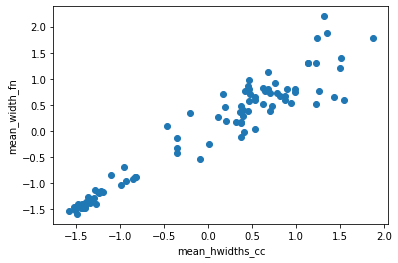

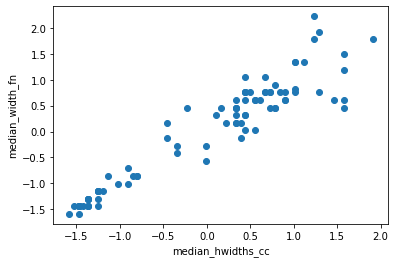

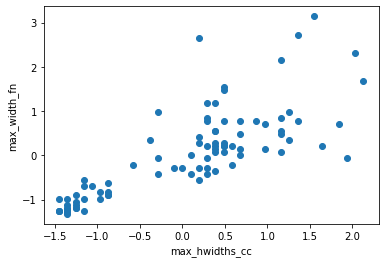

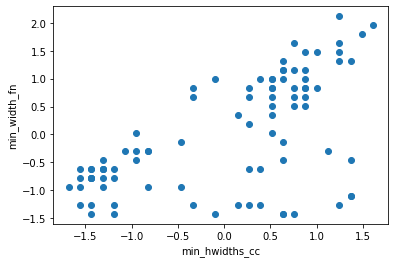

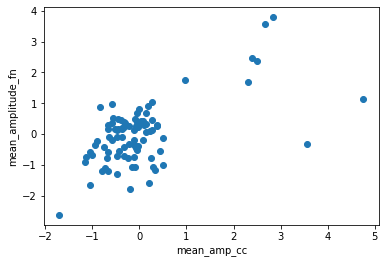

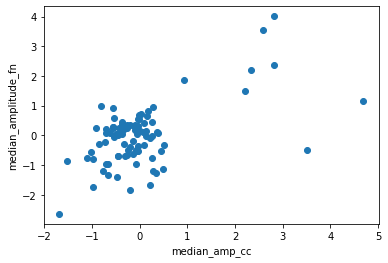

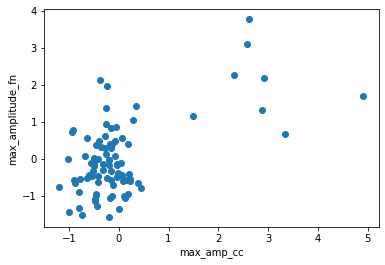

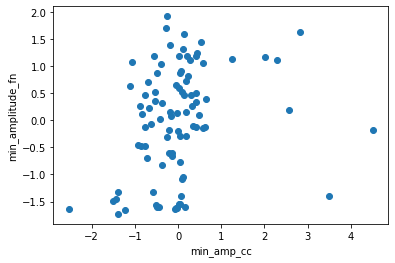

In [86]:
print(data_CC.columns)
data_FN.columns
data_cc_temp = data_CC[['current_first_spike', 'ap_count', 'abs_firing_rate',
       'inst_firing_rate', 'time_to_first_spike', 'mean_isi', 'max_isi',
       'min_isi', 'median_isi', 'first_thrs', 'mean_thrs', 'max_thrs',
       'min_thrs', 'median_thrs', 'mean_hwidths',
       'median_hwidths', 'max_hwidths', 'min_hwidths', 'mean_amp',
       'median_amp', 'max_amp', 'min_amp']]
data_fn_temp = data_FN[['current_at_first_spike', 'ap_count', 'fr', 'inst_fr',
       'time_to_first_spike', 'mean_isi', 'max_isi', 'min_isi','median_isi',
       'first_thr', 'mean_thr','max_thr',  'min_thr', 'median_thr',
       'mean_width', 'median_width', 'max_width', 'min_width',
       'mean_amplitude', 'median_amplitude', 'max_amplitude', 'min_amplitude']]
def standardize(data):
    return (data-np.mean(data))/np.std(data)
for i,j in zip(data_cc_temp.columns,data_fn_temp.columns):
    plt.scatter(standardize(data_cc_temp[i]),standardize(data_fn_temp[j]))
    plt.xlabel(i+'_cc')
    plt.ylabel(j+'_fn')
    plt.show()

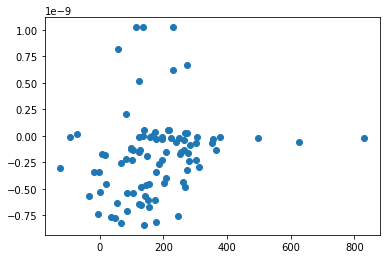

In [73]:
data_FN[['current_at_first_spike', 'ap_count', 'fr', 'inst_fr',
       'time_to_first_spike', 'mean_isi', 'median_isi', 'max_isi', 'min_isi',
       'first_thr', 'mean_thr', 'median_thr', 'min_thr', 'max_thr',
       'mean_width', 'median_width', 'max_width', 'min_width',
       'mean_amplitude', 'median_amplitude', 'min_amplitude', 'max_amplitude',
       'exp_name', 'cond']]
plt.scatter(data_FN['current_at_first_spike'],data_CC['current_first_spike'])
# data_CC['current_at_first_spike']

In [160]:
import numpy as np
from sklearn.decomposition import PCA
X_CC = data_cc_temp.to_numpy() #data_all_CC
X_FN = data_fn_temp.to_numpy() #data_all_FN


pca = PCA(min(X_FN.shape[1],X_CC.shape[1]))
FN_transform =X_FN# pca.fit_transform(X_FN)
CC_transform =X_CC# pca.fit_transform(X_CC)


In [126]:
X_FN.shape

(90, 22)

In [161]:
SHUFFLED = True

while SHUFFLED:
    indices_rand1 = np.arange(90)
    indices_rand2 = np.arange(90)
    np.random.shuffle(indices_rand1)
    np.random.shuffle(indices_rand2)
    if len(np.where(indices_rand1-indices_rand2==0)[0])==0:
        SHUFFLED=False
        print('here')


here


In [162]:
FN_X = np.vstack([FN_transform,FN_transform[indices_rand1]])
CC_X = np.vstack([CC_transform,CC_transform[indices_rand2]])
y = np.hstack([np.ones(90),np.zeros(90)])


In [174]:
all_idx = np.arange(len(FN_X))
# np.random.shuffle(all_idx)
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

X1_train = []
X2_train = []
y_train = []
X1_test = []
X2_test = []
y_test = []
X1_train,X1_test,X2_train,X2_test, y_train, y_test = train_test_split(FN_X,CC_X, y, test_size=0.33, random_state=42)# kf = KFold(n_splits=2)
# for train, test in kf.split(all_idx):
#     X1_train.append(FN_X[train]) 
#     X2_train.append(CC_X[train]) 
#     y_train.append(y[train])
#     X1_test.append(FN_X[test])
#     X2_test.append(CC_X[test])
#     y_test.append(y[test])


In [177]:
X1_train =np.vstack(X1_train)
X2_train =np.vstack(X2_train)
y_train =np.hstack(y_train)
X1_test =np.vstack(X1_test)
X2_test =np.vstack(X2_test)
y_test =np.hstack(y_test)
print(y_test.shape)

(60,)


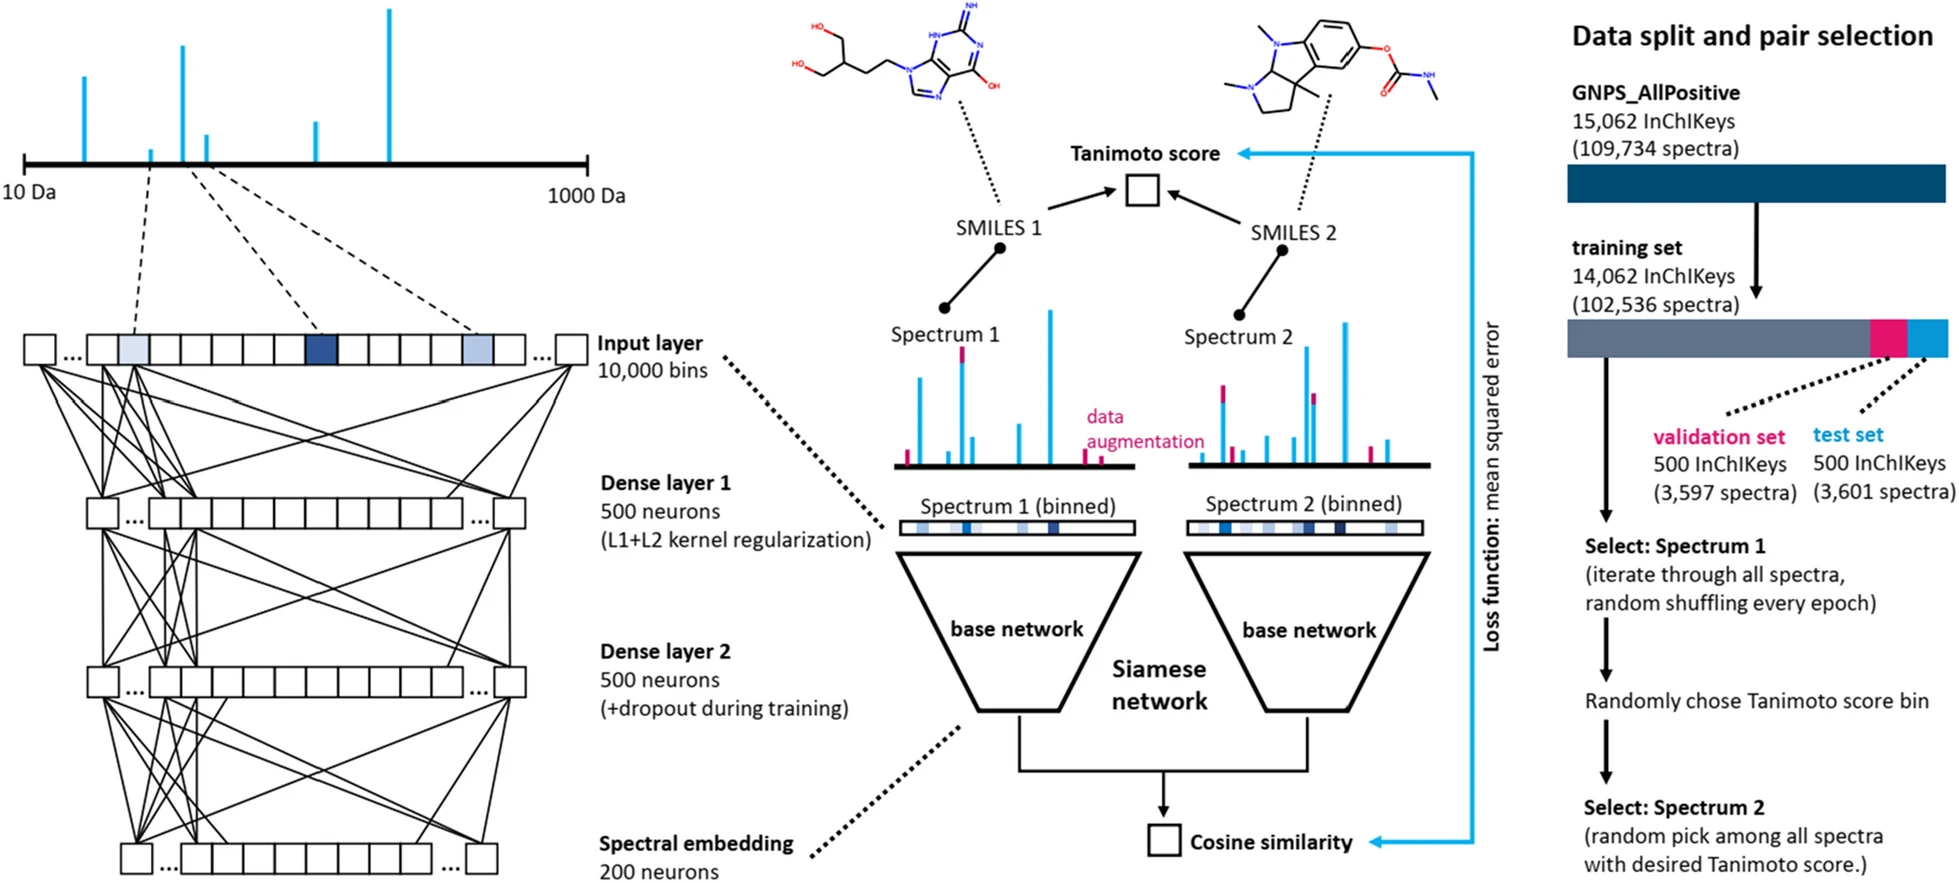

## Model training

Initialize a SiameseModel. It consists of a dense 'base' network that produces an embedding for each of the 2 inputs. The 'head' model computes the cosine similarity between the embeddings.

In [178]:
model = SiameseModel(22, base_dims=(10, 10), embedding_dim=5,
                         dropout_rate=0.5)
model.compile(loss='mse', optimizer=Adam(learning_rate=0.01), metrics=["mae", tf.keras.metrics.RootMeanSquaredError()])

# Save best model and include earlystopping
earlystopper_scoring_net = EarlyStopping(monitor='val_loss', mode="min", patience=10, verbose=1, restore_best_weights=True)
model.summary()

Model: "base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base_input (InputLayer)     [(None, 22)]              0         
                                                                 
 dense1 (Dense)              (None, 10)                230       
                                                                 
 normalization1 (BatchNorma  (None, 10)                40        
 lization)                                                       
                                                                 
 dense2 (Dense)              (None, 10)                110       
                                                                 
 normalization2 (BatchNorma  (None, 10)                40        
 lization)                                                       
                                                                 
 dropout2 (Dropout)          (None, 10)                0      

Train the model. The model will continue for 150 epochs or will stop if the validation loss did not decrease for 10 epochs.

In [150]:
np.random.shuffle(y_train)

# np.random.shuffle(y_train)

In [179]:
history = model.model.fit(x={'input_a':X1_train,'input_b':X2_train},y=y_train.astype('float32'), 
                        #   batch_size=10,
                          validation_data=({'input_a':X1_test,'input_b':X2_test},y_test),
                          epochs=150, 
                          verbose=1, 
                          callbacks=[earlystopper_scoring_net])

Epoch 1/150
4/4 [==============================] - 3s 151ms/step - loss: 0.3563 - mae: 0.4675 - root_mean_squared_error: 0.5969 - val_loss: 0.4329 - val_mae: 0.5333 - val_root_mean_squared_error: 0.6579
Epoch 2/150
4/4 [==============================] - 0s 24ms/step - loss: 0.3453 - mae: 0.4700 - root_mean_squared_error: 0.5876 - val_loss: 0.4328 - val_mae: 0.4905 - val_root_mean_squared_error: 0.6578
Epoch 3/150
4/4 [==============================] - 0s 29ms/step - loss: 0.3933 - mae: 0.4941 - root_mean_squared_error: 0.6271 - val_loss: 0.4323 - val_mae: 0.5015 - val_root_mean_squared_error: 0.6574
Epoch 4/150
4/4 [==============================] - 0s 28ms/step - loss: 0.3292 - mae: 0.4425 - root_mean_squared_error: 0.5737 - val_loss: 0.4476 - val_mae: 0.5153 - val_root_mean_squared_error: 0.6690
Epoch 5/150
4/4 [==============================] - 0s 26ms/step - loss: 0.2981 - mae: 0.4102 - root_mean_squared_error: 0.5459 - val_loss: 0.4522 - val_mae: 0.5239 - val_root_mean_squared_err

Save the model (if you want to)

In [74]:
model_file_name = os.path.join(TEST_RESOURCES_PATH, "ms2deepscore_model.hdf5")
model.save(model_file_name)

NameError: name 'TEST_RESOURCES_PATH' is not defined

Code to later lode in the model again


In [11]:
model = load_model(model_file_name)

Plot the validation and training loss, to check for overfitting.

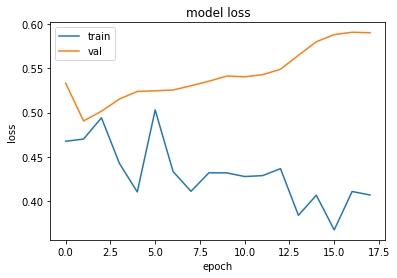

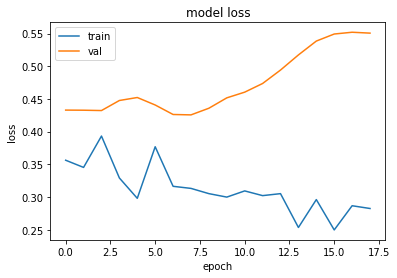

In [181]:
from matplotlib import pyplot as plt
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Model inference

Calculate similariteis for a pair of spectra

In [106]:
similarity_measure = MS2DeepScore(model)
score = similarity_measure.pair_(X1_test[0], X2_test[1])
print(score)

AttributeError: 'SiameseModel' object has no attribute 'nr_of_additional_inputs'

Calculate similarities for a 3x3 matrix of spectra

In [14]:
scores = similarity_measure.matrix(spectrums_validation[:3], spectrums_validation[:3])
print(scores)

Calculating vectors of reference spectrums: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 28.10it/s]


[[1.         0.69266849 0.59288358]
 [0.69266849 1.         0.50841891]
 [0.59288358 0.50841891 1.        ]]
